In [18]:
from matplotlib import pyplot as plt
from pathlib import Path
import mediapipe as mp
import numpy as np
import cv2

In [19]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
PL = mp_pose.PoseLandmark

In [20]:
PROJ_DIR = Path('/Users/lyronctk/Desktop/projects/trainer')
TEST_IM_PATH = PROJ_DIR / 'data/test_im.png'

In [21]:
def preview_im(image):
    rgb = image[:,:,::-1]
    fig = plt.figure()
    fig.set_size_inches(25, 10)
    plt.imshow(rgb)

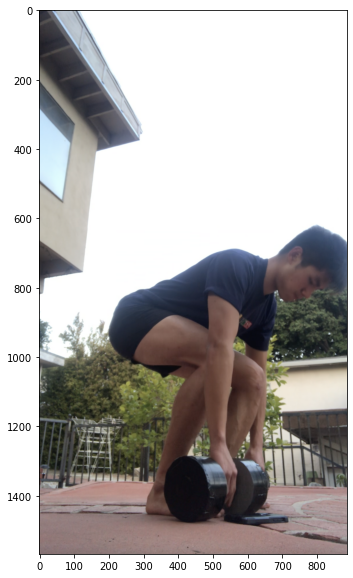

In [22]:
image = cv2.imread(str(TEST_IM_PATH))
preview_im(image)

In [23]:
[e.name for e in PL] 

['NOSE',
 'LEFT_EYE_INNER',
 'LEFT_EYE',
 'LEFT_EYE_OUTER',
 'RIGHT_EYE_INNER',
 'RIGHT_EYE',
 'RIGHT_EYE_OUTER',
 'LEFT_EAR',
 'RIGHT_EAR',
 'MOUTH_LEFT',
 'MOUTH_RIGHT',
 'LEFT_SHOULDER',
 'RIGHT_SHOULDER',
 'LEFT_ELBOW',
 'RIGHT_ELBOW',
 'LEFT_WRIST',
 'RIGHT_WRIST',
 'LEFT_PINKY',
 'RIGHT_PINKY',
 'LEFT_INDEX',
 'RIGHT_INDEX',
 'LEFT_THUMB',
 'RIGHT_THUMB',
 'LEFT_HIP',
 'RIGHT_HIP',
 'LEFT_KNEE',
 'RIGHT_KNEE',
 'LEFT_ANKLE',
 'RIGHT_ANKLE',
 'LEFT_HEEL',
 'RIGHT_HEEL',
 'LEFT_FOOT_INDEX',
 'RIGHT_FOOT_INDEX']

In [24]:
def extract_coords(results, landmark):
    lms = results.pose_landmarks.landmark
    return (lms[landmark].x, lms[landmark].y, lms[landmark].z)

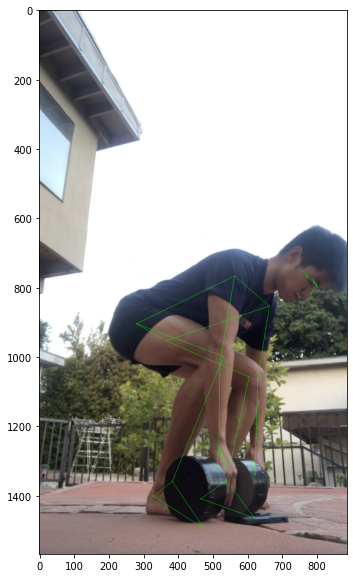

In [25]:
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
if not results.pose_landmarks:
  raise ValueError("Pose landmarks not found.")

results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

annotated_image = image.copy()
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=results.pose_landmarks,
    connections=mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=drawing_spec,
    connection_drawing_spec=drawing_spec)
preview_im(annotated_image)

In [17]:
extract_coords(results, PL.RIGHT_HIP)

(0.3169783353805542, 0.5768055319786072, -0.14726737141609192)